In [1]:
# install dependencies
!pip install tweet-preprocessor==0.6.0
!pip install tensorflow==2.3.1
!pip install requests==2.25.0
# Tensorflow 2.3.1 requires numpy < 1.19.0
# !pip install numpy==1.19.0
!pip install pandas==1.1.4
!pip install tweet-preprocessor==0.6.0
!pip install tqdm==4.52.0

In [2]:
# define required libraries
import io
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preprocessor as p
import requests
import tensorflow as tf
from tqdm import tqdm

In [3]:
# prepare dataset
DATA_SET_URL = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
# extract zip file to data directory (generated if not exists)
DEST_DIR = './data'

r = requests.get(DATA_SET_URL, stream=True)
with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
    zf.extractall(DEST_DIR)

train_data_file_path = os.path.join(DEST_DIR, 'training.1600000.processed.noemoticon.csv')

assert(os.path.exists(train_data_file_path))

In [4]:
# read data
# note that we use polarity as label (0 = negative, 4 = positive)
# use only tweet and polarity columns
USED_COLS = ['tweet', 'polarity']
df = pd.read_csv(train_data_file_path, encoding='ISO-8859-1', header=None)
df.columns = ['polarity', 'tweet_id', 'date_of_tweet', 'query', 'user', 'tweet']
df = df[USED_COLS]

# relabel polarity from 4 to 1
df.loc[df['polarity'] == 4, 'polarity'] = 1
df.head()

,tweet,polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [5]:
# preprocess tweets
# NOTE that p.clean should also be used in streaming pipeline
def preprocess_tweet(row):
    return p.clean(row)

# show progress
tqdm.pandas()
df['tweet'] = df['tweet'].progress_apply(preprocess_tweet)
df.head()

/home/josh9191/anaconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1600000/1600000 [01:35<00:00, 16741.55it/s]


,tweet,polarity
0,"- Awww, that's a bummer. You shoulda got David...",0
1,is upset that he can't update his Facebook by ...,0
2,I dived many times for the ball. Managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am ...",0


In [6]:
# train - val - test dataset split
# the code below shuffles dataframe and split dataset (6:2:2)
train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(len(train_df), len(val_df), len(test_df))

960000 320000 320000


In [7]:
# we use RNN to train data
# create vocabulary and encode data
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_df['tweet'].values)

vocab = np.array(encoder.get_vocabulary())
print("[First 20 vocabularies]")
vocab[:20]

[First 20 vocabularies]


array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'of', 'im', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U13')

In [8]:
# define sentiment analysis model
# TextVectorization -> Embedding -> Bidrectional -> Dense
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, name='output', activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-3),
              metrics=['accuracy'])

In [9]:
# fit model
# enable early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=train_df['tweet'].values, y=train_df['polarity'].values,
                    batch_size=256, epochs=30,
                    callbacks=early_stopping_callback,
                    validation_data=(val_df['tweet'].values, val_df['polarity'].values),
                    validation_steps=30)

Epoch 1/30
3750/3750 [==============================] - 352s 94ms/step - loss: 0.6904 - accuracy: 0.5366 - val_loss: 0.6850 - val_accuracy: 0.5931
Epoch 2/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.6659 - accuracy: 0.6231 - val_loss: 0.6421 - val_accuracy: 0.6879
Epoch 3/30
3750/3750 [==============================] - 349s 93ms/step - loss: 0.6211 - accuracy: 0.7253 - val_loss: 0.6152 - val_accuracy: 0.7488
Epoch 4/30
3750/3750 [==============================] - 348s 93ms/step - loss: 0.6123 - accuracy: 0.7471 - val_loss: 0.6098 - val_accuracy: 0.7510
Epoch 5/30
3750/3750 [==============================] - 351s 93ms/step - loss: 0.6098 - accuracy: 0.7534 - val_loss: 0.6092 - val_accuracy: 0.7556
Epoch 6/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.6087 - accuracy: 0.7599 - val_loss: 0.6075 - val_accuracy: 0.7607
Epoch 7/30
3750/3750 [==============================] - 350s 93ms/step - loss: 0.6080 - accuracy: 0.7613 - val_loss: 0

In [10]:
test_loss, test_acc = model.evaluate(x=test_df['tweet'].values, y=test_df['polarity'].values)
print(f'Test Loss: {test_loss} / Test Accuracy: {test_acc}')

10000/10000 [==============================] - 99s 10ms/step - loss: 0.6080 - accuracy: 0.7598
Test Loss: 0.607958197593689 / Test Accuracy: 0.7597812414169312


(0.0, 0.6946089565753937)

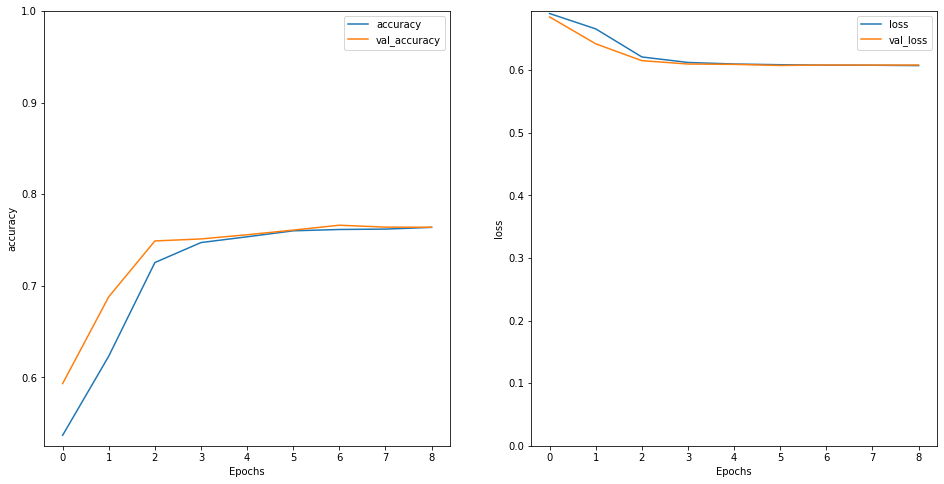

In [11]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [12]:
# save the model
model.save('./model', save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/assets


In [38]:
rows = 20
pd.set_option('display.float_format', lambda x: '%.6f' % x)
sample_result = pd.DataFrame({'text': test_df['tweet'][:20].values, 'pred': model.predict(test_df['tweet'][:20].values)[:, 0]})
sample_result

,text,pred
0,I do this from hanging out with chris too much...,0.000000
1,she's smarter and classier. she's perfect for ...,0.000000
2,F*ck! My Internet is down. withdrawals......sh...,0.000000
3,Small puncture attack by sofa staple has resul...,0.000000
4,Oh toonightt soo excited!,1.000000
5,Bordeaux is moving to screwcaps? ... surely yo...,0.998019
6,Everyone said when you have a baby you'll neve...,0.186350
7,It's so difficult that could replies me with a...,0.999997
8,Heck yeah!,1.000000
9,Happy Twitter Sunday,1.000000


In [ ]:
# use gsutil to upload directory to Cloud Storage bucket
# gsutil cp -r model gs://my-bucket